# Rank correlation performance measurement for External Corrosion (EC) model

This notebook will apply the rank correlation approach for measuring model performance outlined in [time dependent metric proposal](https://pge-my.sharepoint.com/:w:/r/personal/a1yu_pge_com/Documents/Documents/docs/performance_metric/time_depenedent_metric_proposal.docx?d=wd68c4250255d42a4b6279a5389502474&csf=1&web=1&e=6MIx7t) to external corrosion. The implementations here tries the idea of using ILI failure pressure as describe in the [v0 doc](https://pge-my.sharepoint.com/:w:/r/personal/a1yu_pge_com/Documents/Documents/docs/performance_metric/time_depenedent_metric_proposal.docx?d=wd68c4250255d42a4b6279a5389502474&csf=1&web=1&e=6MIx7t).

## Approach

For this try, we want to do the following:

1. Get the failure pressure for the pipelines that have ILI data available.
2. Calculate the EC algorithm LOF for pipelines that have the ILI data available. Note that by default, POE is used to calculate LOF for pipelines with ILI data.
3. Compare the results

## ILI data

Using the ILI failure pressure data is not straight-forward, however, especially if we want to grab it directly from the marinerDB.

The main reason is that ILI tally lists indidivudal defects and flaws detected. A pipe segment can have multiple defects. Consequently, the failure pressure from ILI is PER DEFECT. In contrast, the failure pressure calculated as part of the POE-LOF process is PER SEGMENT. While both Jackson and Brian suggests using the ILI tally failure pressure, the per-defect failure pressure need to be converted to per-segment failure pressure, such that they can be matched against the EC risk model outputs.


**Additional caveats**

- Check the install date of the pipe that I'm comparing against to be before the ILI data.
- In the LOF-Alg calculation (non-POE), a mitigation factor is applied. Could be useful to run calculation with/without it.tion with/without it.

## Access the ILI failure pressure information from the marinerDB

In [6]:
import sqlalchemy
from sqlalchemy import create_engine

from sqlalchemy import MetaData, Table

In [2]:
# Example from https://stackoverflow.com/a/75545100

server = "tsitinfdbsws010"
database = "MarinerDB_2022"
driver = "ODBC+Driver+17+for+SQL+Server"
url = f"mssql+pyodbc://{server}/{database}?trusted_connection=yes&driver={driver}"
engine = sqlalchemy.create_engine(url)
connection = engine.connect()

In [3]:
from sqlalchemy import inspect
inspector = inspect(engine)
table_names = inspector.get_table_names()

In [4]:
table_names

['A_Form',
 'A_Form_CoverDepth',
 'ACAnnualPrecip',
 'ACDryChlorideDep',
 'ACSpans',
 'acspans_stage1_scc',
 'acspans_stage1_tpd',
 'ACSulfurDioxDep',
 'ACVaults',
 'anaRiskScores_2022',
 'anariskscores_2022_bk041023',
 'anaRiskScores_LOF_COF_2022',
 'anaRiskScores_pipe',
 'anaWAP_IDevents',
 'ArcFaultHistory',
 'Assessment_History',
 'assessment_history_bk110422',
 'Assessment_History_Cons',
 'Assessment_History_ILI',
 'Assessment_History_Manu',
 'assessment_plan',
 'assessment_plan_bk090922',
 'assessment_plan_stage1_ec',
 'assessment_plan_stage1_ic',
 'assessment_plan_stage1_scc',
 'AxialSCCLeak',
 'axialsccleak_stage1',
 'Bend',
 'bend_2022',
 'bend_bk0712',
 'bend_dups',
 'buffersize',
 'CA_2023_05',
 'CA_Categories',
 'Carefacility_IOC',
 'carefacility_ioc_tmp120122',
 'CASING',
 'casing_stage1',
 'CasingRawData',
 'Centerline_Per_Series',
 'Centerline_PIR',
 'classarea',
 'classarea_tmp101722',
 'classarea_upd101722',
 'coating',
 'Coating_assume_type',
 'Coating_Condition',
 'c

In [12]:
from sqlalchemy import MetaData, Table
metadata_obj = MetaData()
Table_POE_TRADILI_MATCHED_2022 = Table("POE_TRADILI_MATCHED_2022", metadata_obj, autoload_with=engine)

In [13]:
type(Table_POE_TRADILI_MATCHED_2022)

sqlalchemy.sql.schema.Table

In [14]:
# print(select(user_table.c.name, address_table.c.email_address))
from sqlalchemy import select

ILI_failure_pressure_columns = [
    "FAILUREPRESSURE_PSI",
    "FAILUREPRESSURERATIO",
    "FAILUREPRESSURETOLERANCE_PSI",
    "FAILUREPRESSURERATIOTOLERANCE",
]
stmt = select(*[Table_POE_TRADILI_MATCHED_2022.c[column] for column in ILI_failure_pressure_columns])
print(stmt)

SELECT "POE_TRADILI_MATCHED_2022"."FAILUREPRESSURE_PSI", "POE_TRADILI_MATCHED_2022"."FAILUREPRESSURERATIO", "POE_TRADILI_MATCHED_2022"."FAILUREPRESSURETOLERANCE_PSI", "POE_TRADILI_MATCHED_2022"."FAILUREPRESSURERATIOTOLERANCE" 
FROM "POE_TRADILI_MATCHED_2022"


In [15]:
results = connection.execute(stmt).fetchall()

In [16]:
results[0]

(None, Decimal('0E-8'), None, Decimal('0E-8'))

By default the above statement will get all the values, and use the default numeric type of `decimal`, which can create problem with numpy functions down the line. So we want to cast everything to float instead!

In [17]:
from sqlalchemy import cast, Float
columns_to_select = [
    cast(Table_POE_TRADILI_MATCHED_2022.c[column], Float)
    # if Table_POE_TRADILI_MATCHED_2022.c[column].type.__class__.__name__ == "DECIMAL"
    # else Table_POE_TRADILI_MATCHED_2022.c[column]
    for column in ILI_failure_pressure_columns
]
query = select(*columns_to_select)

In [18]:
results = connection.execute(query).fetchall()

In [19]:
results[0]

(None, 0.0, None, 0.0)

In [20]:
# Move it into a pandas data frame
import pandas as pd
df_ILI_failure_pressure = pd.DataFrame(results, columns=ILI_failure_pressure_columns)
# convert 

In [21]:
df_ILI_failure_pressure["FAILUREPRESSURE_PSI"].notna().sum() / len(df_ILI_failure_pressure)

0.33883750687210823

Roughly 33% of all ILI rows have some kind of failure pressure.

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(style="darkgrid")

In [38]:
failure_pressure_psi = df_ILI_failure_pressure["FAILUREPRESSURE_PSI"][df_ILI_failure_pressure["FAILUREPRESSURE_PSI"].notna()]

(0.0, 3500.0)

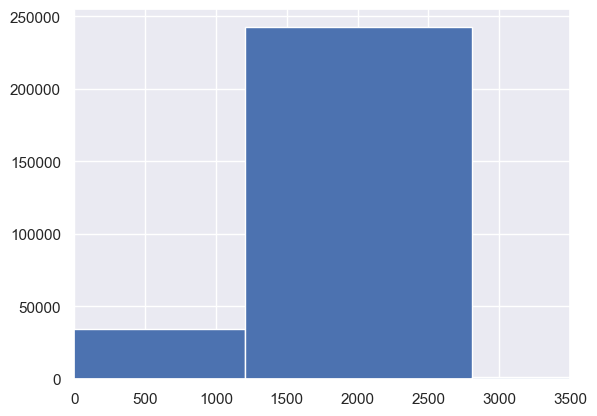

In [39]:
plt.hist(failure_pressure_psi);
plt.xlim([0, 3500])

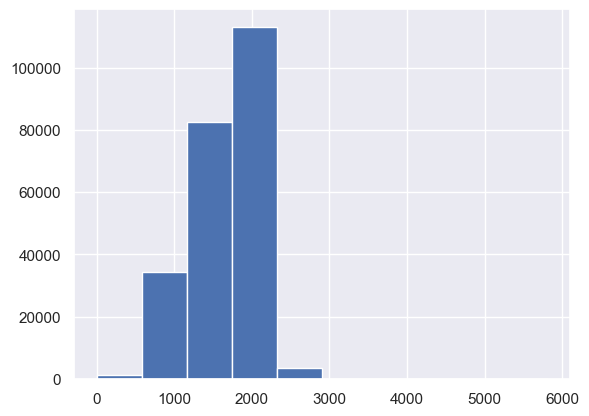

In [40]:
failure_pressure_tolerance_psi = df_ILI_failure_pressure["FAILUREPRESSURETOLERANCE_PSI"][df_ILI_failure_pressure["FAILUREPRESSURETOLERANCE_PSI"].notna()]
plt.hist(failure_pressure_tolerance_psi);

In [41]:
np.percentile(failure_pressure_psi.values, [1., 50., 95.])

array([1047.21, 1819.13, 2126.49])

In [42]:
np.min(failure_pressure_psi)

-9999.90039063

In [43]:
np.argmin(failure_pressure_tolerance_psi)

182736

In [44]:
len(failure_pressure_psi)

278580

Something is wrong... we have negative failure pressure (is it from conversion?), and also very very small failure pressure, which is very bad if true.

In [46]:
df_ILI_failure_pressure["FAILUREPRESSURE_PSI"][df_ILI_failure_pressure["FAILUREPRESSURE_PSI"] < 0]

89391    -9999.900391
96906    -9999.900391
96939    -9999.900391
97067    -9999.900391
97068    -9999.900391
             ...     
765253   -9999.900391
776475   -9999.900391
776507   -9999.900391
776520   -9999.900391
776563   -9999.900391
Name: FAILUREPRESSURE_PSI, Length: 204, dtype: float64

In [47]:
(df_ILI_failure_pressure["FAILUREPRESSURE_PSI"] <= 5).sum()

234

In [48]:
np.min(failure_pressure_psi[failure_pressure_psi > 0])

3.32

According to 2022 ILI tally, the minimum value is 663..not sure why we get negative values.

## Access the EC-algorithm LOF values from the database

Model results calculated using the LOF-Algorithm (not POE) for the pipe segments with available ILI data -- do I get them from failure_pressure table or something else?
Answer: Use EC_RISK_LOF table to get the non-POE EC risk lofs. "Turns out I don't have the non-POE EC LOFs in the RiskResults_int2022 table after all" (Jackson)

In [49]:
Table_EC_Risk_LOF = Table("EC_Risk_LOF", metadata_obj, autoload_with=engine)

In [50]:
# Find rows for which ILI completion date is in 2022
from datetime import datetime
threshold_date = datetime(2022, 1, 1)
query = select(Table_EC_Risk_LOF).where(Table_EC_Risk_LOF.c.ILI_Completion_Date > threshold_date)
with engine.connect() as connection:
    LOF_2022 = connection.execute(query).fetchall()

In [51]:
LOF_2022[0]._mapping

{'sortid': 316529, 'route': '1202-16', 'beginstationseriesid': '36339', 'beginstationnum': 17504.4, 'endstationseriesid': '36339', 'endstationnum': 17504.600000000002, 'Mainline_Coating_Type': 'H', 'Dry_Chloride_Deposition': 0.6200000047683716, 'Third_Party_Liquid_Proximity': None, 'Third_Party_Gas_Proximity': None, 'Lack_Casing_Test_Facilities': None, 'Casing': None, 'Annual_Precipitation': 32.77000045776367, 'ILI_Assessment_Method': 'ILI', 'ILI_Completion_Date': datetime.datetime(2022, 3, 28, 0, 0), 'Soil_Type': 'L', 'Soil_Resistivity': None, 'Foreign_Line_Crossing': None, 'Percent_Wall_Loss': Decimal('37.60'), 'Reassessment_Interval': Decimal('7'), 'Direct_Examination': None, 'Hydrotest_Completion_Date': None, 'Span_Prioritization': None, 'Span_Support': None, 'Span_Condition': None, 'Vault_Condition': None, 'Feature_Type': 'PIPE', 'PFL_Feature_Num': '147.00000', 'Manufacture_Date': datetime.datetime(1953, 8, 8, 0, 0), 'Pipe_Material': 'STL', 'Seam_Type_Assumed': 'Assumptions Calcul

In [52]:
len(LOF_2022)

24803

In [53]:
from sqlalchemy import func

with engine.connect() as connection:
    row_counts = connection.execute(
        select(func.count()).select_from(Table_EC_Risk_LOF)
    ).fetchall()


In [54]:
row_counts

[(900650,)]

In [55]:
24803/900650

0.027538999611391772

About 2.75% of all pipelines have ILI data in 2022.

In [56]:
# Push the entire table into pandas dataframe
df_EC_Risk_LOF = pd.DataFrame(LOF_2022, columns=LOF_2022[0]._mapping.keys())

In [57]:
ec_lof_leak = df_EC_Risk_LOF["EC_LOF_Leak"]
ec_lof_rupture = df_EC_Risk_LOF["EC_LOF_Rupture"]

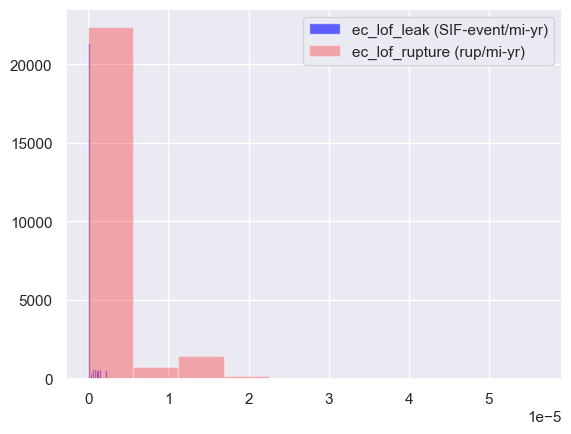

In [58]:
plt.figure()
plt.hist(ec_lof_leak, color='blue', alpha=0.6)
plt.hist(ec_lof_rupture, color='red', alpha=0.3)
plt.legend(["ec_lof_leak (SIF-event/mi-yr)", "ec_lof_rupture (rup/mi-yr)"])

Text(0, 0.5, 'rupture lof')

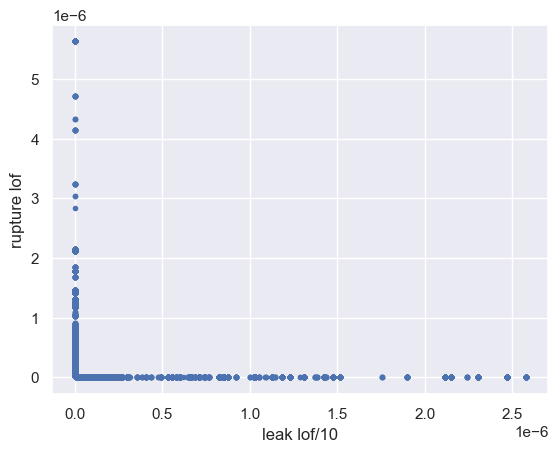

In [59]:
plt.plot(ec_lof_leak, ec_lof_rupture/10, '.')
plt.xlabel("leak lof/10")
plt.ylabel("rupture lof")

In [63]:
df_EC_Risk_LOF.columns.values

array(['sortid', 'route', 'beginstationseriesid', 'beginstationnum',
       'endstationseriesid', 'endstationnum', 'Mainline_Coating_Type',
       'Dry_Chloride_Deposition', 'Third_Party_Liquid_Proximity',
       'Third_Party_Gas_Proximity', 'Lack_Casing_Test_Facilities',
       'Casing', 'Annual_Precipitation', 'ILI_Assessment_Method',
       'ILI_Completion_Date', 'Soil_Type', 'Soil_Resistivity',
       'Foreign_Line_Crossing', 'Percent_Wall_Loss',
       'Reassessment_Interval', 'Direct_Examination',
       'Hydrotest_Completion_Date', 'Span_Prioritization', 'Span_Support',
       'Span_Condition', 'Vault_Condition', 'Feature_Type',
       'PFL_Feature_Num', 'Manufacture_Date', 'Pipe_Material',
       'Seam_Type_Assumed', 'Seam_Type', 'Install_Date',
       'ECDA_Length_of_Mon', 'ECDA_Length_of_Sched', 'ECDA_Length_of_Imm',
       'ECDA_Project_Length', 'ECDA_Wall_Loss_GTE50',
       'ECDA_Wall_Loss_GTE40LT50', 'ECDA_Wall_Loss_GTE30LT40',
       'ECDA_Wall_Loss_GTE20LT30', 'ECDA_Num

In [64]:
len(df_EC_Risk_LOF)

24803